# Patent Reduction

## Purpose

The purpose of this program is to identify the core similiarities between 42 patents and applications, and reduce their number to the top 3 or 4 based on ngrams and other factors.

## Work Plan

- Get full text of patents
- Analyze ngrams of pantents
- Identify embeddings 
- Conduct dimension reduction technique

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re

In [2]:
patent_folder ='./Patents/gp-search-20170622-225739.csv'

In [3]:
df = pd.read_csv(patent_folder, skiprows=1)

In [4]:
df.head()

,id,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link
0,US7286245B2,Method and apparatus for determining the influ...,Carl Zeiss Smt Ag,"Ulrich Wegmann, Michael Hartl, Markus Mengel, ...",2002-07-29,2003-07-29,2007-10-23,2007-10-23,https://patents.google.com/patent/US7286245B2/en
1,US20080043236A1,Optical Property Measurement Apparatus and Opt...,Nikon Corporation,"Koji Kaise, Toru Fujii, Yasushi Mizuno",2004-08-09,2005-08-09,2008-02-21,NaN,https://patents.google.com/patent/US2008004323...
2,US7277182B2,Apparatus for polarization-specific examinatio...,Carl Zeiss Smt Ag,"Ulrich Wegmann, Markus Mengel",2003-07-05,2004-07-06,2007-10-02,2007-10-02,https://patents.google.com/patent/US7277182B2/en
3,US6788389B2,Production method of projection optical system,Nikon Corporation,"Youhei Fujishima, Hironori Ikezawa, Toshihiko ...",2001-07-10,2002-07-10,2004-09-07,2004-09-07,https://patents.google.com/patent/US6788389B2/en
4,US6870668B2,Method for evaluating image formation performa...,Nikon Corporation,Toshihiko Ozawa,2000-10-10,2001-10-09,2005-03-22,2005-03-22,https://patents.google.com/patent/US6870668B2/en


In order to download the text of each of the patents listed above, we'll use the unique urls for each patent provided by the United States Patent and Trademark Office and then scrape the pages using BeautifulSoup. 

## Generating the Unique URLs

Select the "id" column in the data frame. 

In [5]:
patent_id_column=df['id']

Next, create a list that contains each id number

In [6]:
patent_id = [i for i in patent_id_column]

An inspection of the USPTO website reveals that the url for each patent contains the patent number repeated three times within the url. However, the initial 'US' and final 'A1' or 'B2' has been removed. 

To to that end, we need to slice each item in the patent_id list so as to remove the intial two and final two charachers from each item.   

In [7]:
patent_id_numbers =[i[2:-2] for i in patent_id_column]

For example:

In [8]:
patent_id[0] 

'US7286245B2'

versus

In [9]:
patent_id_numbers[0]

'7286245'

Next, we take the patent_id_numbers and insert them into the url template so as to create the unique url for each patent.

To do that, we'll use a for loop where we replace each instance of the patent number with 'i'.

In [10]:
url_list = []
for i in patent_id_numbers:
    #Use each of the unique patent id numbers to create a unique url
    url = "http://patft.uspto.gov/netacgi/nph-Parser?Sect1=PTO1&Sect2=HITOFF&d=PALL&p=1&u=%2Fnetahtml%2FPTO%2Fsrchnum.htm&r=1&f=G&l=50&s1="+i+".PN.&OS=PN/"+i+"&RS=PN/"+i
    url_list.append(url)
    

Now we have a list of the unique urls for each of the patents. 

Next, in order to analyze the text, we need to to get the text from patent's webpage. To do so, we use BeautifulSoup.  

In [11]:

#count = 0
#for url in url_list:
    #opens each of the patent urls, scrapes the page
#    page = urlopen(url)
#   soup = BeautifulSoup(page, 'lxml')
#  count += 1
    #opens and writes a text document with the text for each patent. 
    #each file is named 'patent' and its corresponding number
#    with open('patent{}.txt'.format(count), 'w') as f:
#        f.write(soup.decode('utf8'))
###    

To problems:
1) I keep getting a "ERRNO 104: Connection Error" which requires me to run the above cell several times. 
2) Unfortuanately, some the urls are not actually the patents we're looking for :) To that end, I'm switching back to the Google urls.

## Using Google

The loop below creates a list of urls for each of the patents.

In [12]:
stem = 'https://patents.google.com/patent/'
google_url_list=[]
for patent in patent_id:
    google_url = stem+patent
    google_url_list.append(google_url)

Now we can create a dictionary where the keys are the patent numbers and the values are the patent urls.

In [13]:
google_dict = dict(zip(patent_id, google_url_list))

Next, we loop through each of the urls, scrape the title and abstract from each url, and then write it to a text file.

Also, the files' titles are their patentent numbers.

In [14]:
for k,v in google_dict.items():
    page = urlopen(v)
    soup = BeautifulSoup(page, 'lxml')
    with open('{}.txt'.format(k), 'w') as f:
        f.write(soup.title.text[:-25]) #Removes '        - Google Patents' from the end of the title 
        f.write(soup.abstract.text)

In [15]:
import spacy
from collections import Counter, defaultdict
nlp = spacy.load('en')

In [16]:
docs = []
import os
for filename in os.listdir(os.getcwd()):
    if filename.endswith('.txt'):
        docs.append(nlp(open(filename).read()))

In [17]:
# Get first token of the processed document
doc = docs[0]

# Print sentences (one sentence per line)
for sent in doc.sents:
    print(sent)

US20170068165A1 - Optimum arrangement of actuator and sensor points on an optical elemen
A projection exposure apparatus for semiconductor lithography includes a deformable optical element for the correction of wavefront aberrations.
Actuating units for the deformation of the optical element are in mechanical contact with the optical element by way of contact regions.
The contact regions are arranged in a regular or irregular arrangement outside an optically active region of the optical element.
There are contact regions lying closest to the optically active region and remote contact regions.



In [18]:
#article = read_file('data/article.txt')

keywords = Counter()
for chunk in doc.noun_chunks:
    if nlp.vocab[chunk.lemma_].prob < - 8: # probablity value -8 is arbitrarily selected threshold
        keywords[chunk.lemma_] += 1

keywords.most_common(20)


[('the optical element', 3),
 ('contact region', 2),
 ('us20170068165a1 - optimum arrangement', 1),
 ('actuator', 1),
 ('an optical elemen', 1),
 ('a projection exposure apparatus', 1),
 ('semiconductor lithography', 1),
 ('a deformable optical element', 1),
 ('the correction', 1),
 ('wavefront aberration', 1),
 ('actuate unit', 1),
 ('the deformation', 1),
 ('mechanical contact', 1),
 ('the contact region', 1),
 ('a regular or irregular arrangement', 1),
 ('an optically active region', 1),
 ('the optically active region', 1),
 ('remote contact region', 1)]

In [19]:
cross_similarity_matrix = []

for doc1 in docs:
    cross_similarity_vector = []
    for doc2 in docs:
        cross_similarity_vector.append(doc1.similarity(doc2))
    cross_similarity_matrix.append(cross_similarity_vector)

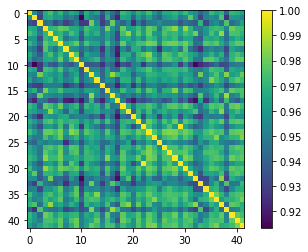

In [20]:
import matplotlib.pyplot as plt
plt.imshow(cross_similarity_matrix, aspect=1)
plt.colorbar()
plt.show()

In [21]:
from sklearn.manifold import TSNE
import numpy as np
# seems very sensitive to random_state , algorith unstable at this time
model = TSNE(n_components=3, random_state=42)
np.set_printoptions(suppress=True)

# doc.vector returns average vector of all tokens, not a good metric, but should work for first try
X = []
for doc in docs:
    X.append(doc.vector)
mapped = model.fit_transform( X ) 

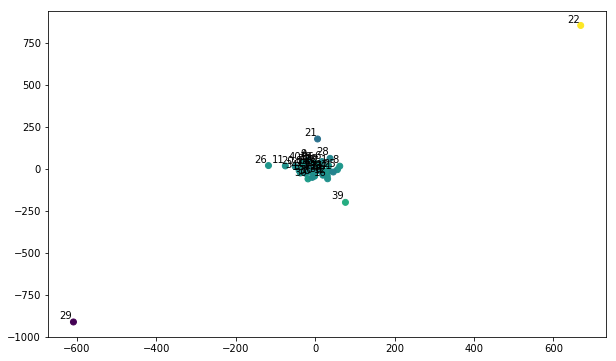

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(mapped[:,0],mapped[:,1], c = mapped[:,2])

for label, x, y in zip(df.index, mapped[:,0],mapped[:,1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom',
      #  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
      #  arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
        )

plt.show()